# Continuous Control : 1 agent

---

## Preamble

### The project

In this notebook, an agent based on the DDPG algorithm is used to solve a continuous control environment for the  [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Before using this notebook check that you have followed the .Readme file available in [GitHub Project repository](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL)

For the Notebook to work you will need the Reacher environment executable which was placed in [GitHub Project repository](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL/Reacher_Windows_x86_64/). The environment needs to uncompressed as  `"./Reacher_Windows_x86_64/Reacher.exe"`

This implementation uses the Pytorch library and was tested in a **Windows 64 bits** platform using **CPU**  computation. 


This notebook is divided in two parts
* **Part 1** : Training. We will train an Agent and see how the learning can be applied to execute a task
* **Part 2** : To see an already trained agent you can skip to Part 2 and load a trained agent.
* **Part 3** : To evaluate a trained agent over 100 episodes. You can skip to Part 1 and load a trained agent.


### Base used for the project

[Shangtong Zhang](https://github.com/ShangtongZhang) implemented several agents and made the implementations in its GITHUB repository. This project is based on its work that was introduced in the Udacity's lectures.  
The base was created to interact with openai and atari environment.
This notebook highlights the modifications allowing the interactions with the Unity environment through the python API.

---

## 1. Part 1 : Training an agent 

### 1.1 Imports and initialisation function
Import the deep_rl libraries from Shangtong and create a function creating the DDPG agent interacting with the Unity environment

In [7]:
from deep_rl import *
import sys

# Init function used to create DDPG agent and initialise its configuration
# DDPG agent for continuous control : https://arxiv.org/abs/1509.02971

def ddpg_low_dim_state_unity():
    config = Config()
    log_dir = get_default_log_dir(ddpg_low_dim_state_unity.__name__)
    # create a task to control the environment. ContinousControl is a new class in task.py
    config.task_fn = lambda **kwargs: ContinuousControl(config.eval_env,log_dir=log_dir)
    # create an Unity environment . New class in deep_rl/component/unity.py
    config.eval_env = Unity()

    # create actor critic network
    # parametres of the network : fully connected 2 hidden layers 400 and 300 units
    # https://arxiv.org/abs/1509.02971 section 7   
    #
    config.network_fn = lambda: DeterministicActorCriticNet(
        config.state_dim, config.action_dim,
        actor_body=FCBody(config.state_dim, (400, 300), gate=F.tanh),
        critic_body=TwoLayerFCBodyWithAction(
            config.state_dim, config.action_dim, (400, 300), gate=F.tanh),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

    config.replay_fn = lambda: Replay(memory_size=int(1e7), batch_size=64)
    config.discount = 0.99
    # use noise generation for exploration 
    # https://arxiv.org/abs/1509.02971 section 7  
    # OrnsteinUhlenbeckProcess used as to generate temporally correlated noise which is 
    # consistent of the training on a continous task where each states are correlated temporally
    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim, ), std=LinearSchedule(0.2))
    # batch size
    config.min_memory_size = 64
    # parametre for blending with target network (see DQN with targets)
    config.target_network_mix = 1e-3
    #remove logger not compatible#config.logger = get_logger()
    return DDPGAgent(config)

The above cell creates a Unity environment base on a new class Unity.
As documented in the Unity.py this class is a wrapper that provides an interface equivalent to the openai gym.
The python API used for the Unity environment is different from open ai. To minimise changes in the agent code a wrapper was created. (see [unity.py](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL/blob/master/deep_rl/component/unity.py))

### 1.2 Training loop


In [8]:
# training loop function
def train(agent,n_episodes=2000, max_t=1000, score_target =30.0):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        # reset environment at the start of each episode
        # None value forces the task.reset call
        agent.state = None
        # episode is not finished
        done = False
        # no reward at start
        score = 0
        for t in range(max_t):
            # The agent step function decides which action to take 
            # then step the environment and store the experience in its memory
            # if enough memory are gathered the agent updates the AC network weights
            agent.step()
            # access reward for monitoring
            score = agent.episode_reward
            if done:
                break 
        # the agent implementation resets the score when episodes is successful
        # as a consequence the reward keeps on cumulating while training
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        # reset agent
        agent.next_state = None
        agent.episode_rewards.append(agent.episode_reward)
        agent.episode_reward = 0
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
        # save network weigth every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            path = 'checkpoint_'+str(i_episode)+'.pth'
            agent.save(path)
            # save score
            f = open('output.txt', 'w')
            f.write('score: '+ str(scores)+'\n')
            f.close()
        # target is 30 to win. 
        if np.mean(scores_window)>=score_target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            path = 'checkpoint_'+str(i_episode)+'.pth'
            agent.save(path)
            break
    return scores



### 1.3 Execute training loop 

In [3]:
# create default directories to maintain compatibility with the base
mkdir('data/video')
mkdir('dataset')
mkdir('log')

# train on CPU and not multi agent training
set_one_thread()
# train on CPU : -1 , GPU = 0
select_device(-1)
# create the agent
agent = ddpg_low_dim_state_unity()
# train the agent
scores = train(agent)
# close the environment at the end of the training
agent.config.eval_env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 3.99	Max Score: 10.25
Episode 200	Average Score: 5.21	Max Score: 9.435
Episode 300	Average Score: 7.56	Max Score: 15.97
Episode 400	Average Score: 8.60	Max Score: 16.73
Episode 500	Average Score: 11.06	Max Score: 19.87
Episode 600	Average Score: 12.77	Max Score: 24.57
Episode 700	Average Score: 12.08	Max Score: 19.31
Episode 800	Average Score: 15.22	Max Score: 30.01
Episode 900	Average Score: 17.70	Max Score: 26.50
Episode 1000	Average Score: 17.56	Max Score: 26.34
Episode 1100	Average Score: 18.31	Max Score: 30.56
Episode 1200	Average Score: 18.02	Max Score: 28.49
Episode 1300	Average Score: 19.70	Max Score: 33.94
Episode 1400	Average Score: 20.40	Max Score: 29.84
Episode 1500	Average Score: 21.22	Max Score: 31.37
Episode 1600	Average Score: 20.71	Max Score: 30.89
Episode 1700	Average Score: 22.74	Max Score: 36.16
Episode 1800	Average Score: 21.99	Max Score: 32.16
Episode 1900	Average Score: 22.28	Max Score: 33.06
Episode 2000	Average Score: 23.12	Max Score:

### 1.3 Plot the training results

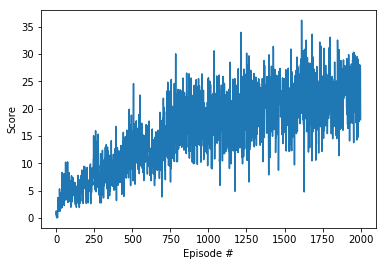

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 1.3 Pursue the training  

In the first training sessions the each episode is 1000 time step long. After 2000 episodes the average score increased but does not meet the "solve" criteria. The score increases until it reaches a plateau.
This can be due to the length of the episode, size of memory and reduced exploration.
The amount of experience the agent can get from one episode is important when not trained are action selection is almost random. So the fact that the sphere as the same behaviour during the full episode does not prevent the agent from learning. However the better the agent is the less he learns for the this consistent environment. The 1000 time steps are temporally correlated and even with a random sampling the we have 1000 memories from which the agent may learn the same thing. If the memory can contain 1e5 timesteps it will store 10 episodes worth of information. 

That is why to accelerate training we reduce the episode length to 500 time steps

In [9]:
# create default directories to maintain compatibility with the base
mkdir('data/video')
mkdir('dataset')
mkdir('log')

# train on CPU and not multi agent training
set_one_thread()
# train on CPU : -1 , GPU = 0
# algorithm was tested on CPU first and to accelerate training was transferred in VM for this attempt
select_device(0)
# create the agent
agent = ddpg_low_dim_state_unity()
scores_2_phase = train(agent, n_episodes=4000, max_t=500, score_target =16.0)
agent.config.eval_env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: 0.23	Max Score: 4.28
Episode 200	Average Score: 0.95	Max Score: 4.34
Episode 300	Average Score: 2.59	Max Score: 6.36
Episode 400	Average Score: 4.61	Max Score: 8.41
Episode 500	Average Score: 6.22	Max Score: 14.37
Episode 600	Average Score: 7.99	Max Score: 14.55
Episode 700	Average Score: 9.27	Max Score: 14.26
Episode 800	Average Score: 10.20	Max Score: 18.74
Episode 900	Average Score: 10.81	Max Score: 17.73
Episode 1000	Average Score: 12.15	Max Score: 18.22
Episode 1100	Average Score: 12.70	Max Score: 18.74
Episode 1200	Average Score: 13.05	Max Score: 18.59
Episode 1300	Average Score: 13.45	Max Score: 18.95
Episode 1400	Average Score: 14.42	Max Score: 19.10
Episode 1500	Average Score: 15.20	Max Score: 19.31
Episode 1600	Average Score: 15.84	Max Score: 19.45
Episode 1630	Average Score: 16.00	Max Score: 19.42
Environment solved in 1630 episodes!	Average Score: 16

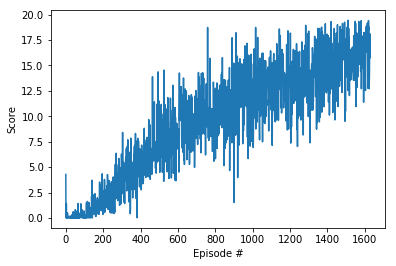

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_2_phase)), scores_2_phase)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 2. Part 2 : Watch a trained agent

In [2]:
# only one agent
num_agents =1
# create the agent
agent = ddpg_low_dim_state_unity()
# load the successful weights
agent.load('./successful_weigths/reacher_one.pth')
#get the brain name
brain_name = agent.config.eval_env.env.brain_names[0]
# reset the Unity env and disable the training mode
env_info = agent.config.eval_env.env.reset(train_mode=False)[brain_name] 
# get initial state
state = env_info.vector_observations[0]
# initialize the score
score = 0                         
while True:
    action = agent.eval_step(state)
    # execute the action in the environment (interface with unity)
    next_state, reward, done, info = agent.config.eval_env.step(action)
    # update current state as next state
    state = next_state
    # cumul rewrd
    score += reward
    if done:                                  # exit loop if episode finished
        break
print('Total score this episode: {}'.format(score))
agent.config.eval_env.close()
agent.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score this episode: 32.09999928250909


## 3. Part 3 : Evaluate a trained agent

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Results 	Average Score: 33.13	Max Score: 39.58\Min Score: 1.06

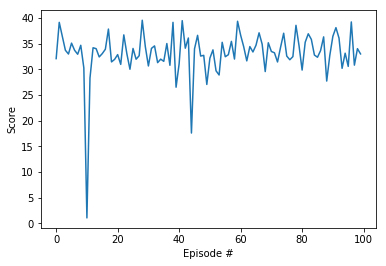

In [3]:
import matplotlib.pyplot as plt

def eval(agent,n_episodes=100):
    # one agent
    num_agents =1
    # get brain name to interface with env
    brain_name = agent.config.eval_env.env.brain_names[0]
    # reset the env and disable training mode
    env_info = agent.config.eval_env.env.reset(train_mode=False)[brain_name] 
    state = env_info.vector_observations[0]
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        score = 0
        while True:
            action = agent.eval_step(state)
            # execute the action in the environment (interface with unity)
            next_state, reward, done, info = agent.config.eval_env.step(action)
            # update current state as next state
            state = next_state
            # cumul rewrd
            score += reward
            if done:                      # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
    return scores

#create agent and launch evaluation
agent = ddpg_low_dim_state_unity()
agent.load('./successful_weigths/reacher_one.pth')
scores = eval(agent)
agent.config.eval_env.close()

#store score in file
f = open('eval.txt', 'w')
f.write('score: '+ str(scores)+'\n')
f.close()

print('\rResults \tAverage Score: {:.2f}\tMax Score: {:.2f}\tMin Score: {:.2f}'.format(np.mean(scores),np.max(scores),np.min(scores)), end="")

#
# plot the evaluation results
#
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()



----

# Annex

Following cells were used in an Udacity workspace (linux VM)

In [5]:
!pip -q install ./python

In [1]:
import zipfile
zip_ref = zipfile.ZipFile('./data/Reacher_Linux_NoVis_one.zip', 'r')
zip_ref.extractall('./data/Reacher_Linux_NoVis_one/')
zip_ref.close()

In [6]:
import os
import stat

for dirpath, dirnames, filenames in os.walk('.'):
    for filename in filenames:
        path = os.path.join(dirpath, filename)
        os.chmod(path, 0o777) # for example